# Feature Extraction – Synthetic Data

Approach:
- Create synthetic drilling data
- Add noise of some characteristic to the data
- Use PCA to see if there are any clusters
- Create new, independent synthetic data
- Add same noise in different termporal locations in the signal 
- Use same PCA scores and look for similar clusters

### Create Synthetic Data

In [47]:
import numpy as np
import matplotlib.pyplot as plt

n = 1000
t = np.arange(1, n+1)
trend = 2 + 0.01 * t
seasonal = np.sin(2 * np.pi * t / 12)
cyclical = np.sin(2 * np.pi * t / 60)
irregular = np.random.randn(n) * 0.3
y = seasonal + cyclical  + trend + irregular

In [48]:
# Create random characteristic noise
noise_size = 100
n_noises = 2
noise_frequencies = np.random.randn(n_noises)
sigmas = np.random.randn(n_noises) * 5
mus = np.random.randn(n_noises)
t_noises = []
for _ in range(n_noises):
    t_noise = [int(np.random.uniform(0, n - noise_size))]
    t_noise.append(t_noise[0] + noise_size)
    t_noises.append(range(t_noise[0], t_noise[1]))
noises = [sigma * np.random.rand(noise_size) + mu for sigma, mu in zip(sigmas, mus)]

In [49]:
y_noise = y.copy()
for t_noise, noise in zip(t_noises, noises):
    y_noise[t_noise] = y_noise[t_noise] + noise
        

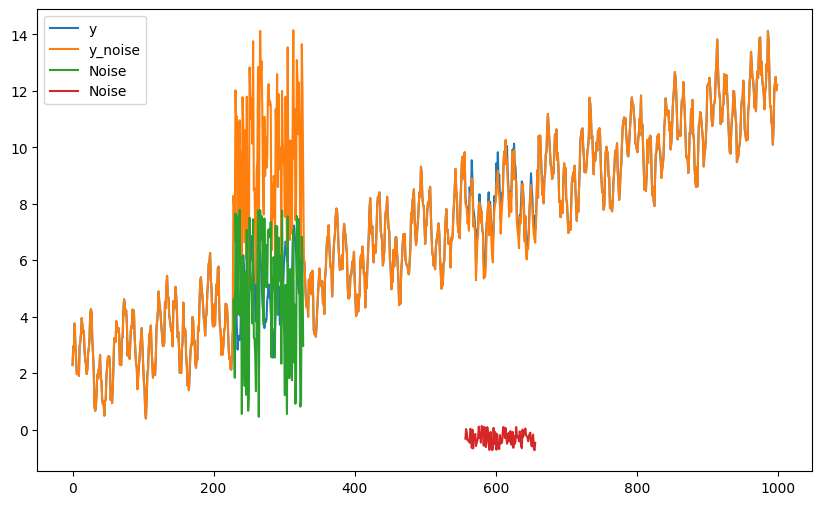

In [51]:
plt.subplots(figsize=(10, 6))
plt.plot(y, label="y")
plt.plot(y_noise, label="y_noise")
#plt.plot(trend, label="trend")
#plt.plot(seasonal, label="seasonal")
#plt.plot(cyclical, label="cyclical")
#plt.plot(irregular, label="irregular")
for t_noise, noise in zip(t_noises, noises):
    plt.plot(t_noise, noise, label="Noise")
plt.legend()

In [5]:
from PyEMD import EMD, Visualisation, EEMD

emd = EMD()
IMFs = emd(y_noise)

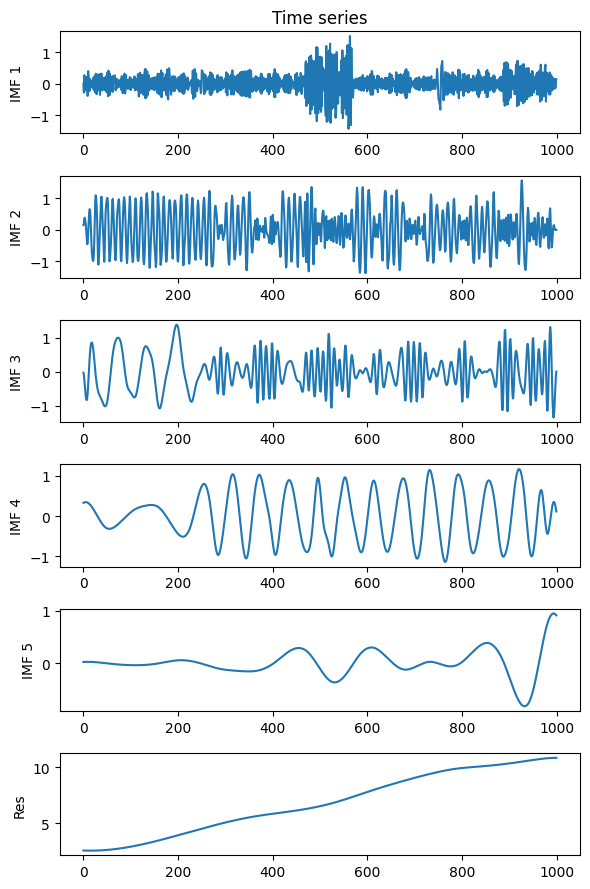

In [6]:
Visualisation(emd).plot_imfs()

In [53]:
# Remove trnd from signal using residual of IMFs
y_noise = y_noise - IMFs[-1]

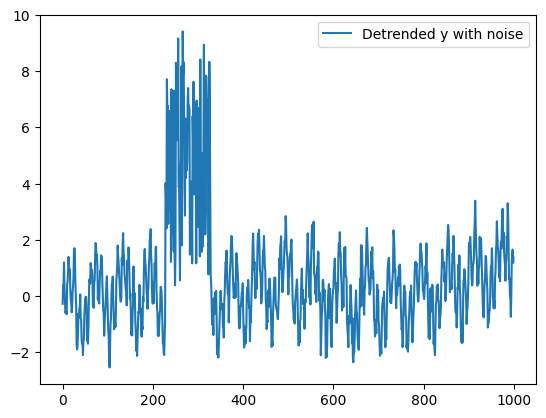

In [54]:
plt.plot(y_noise)
plt.legend(["Detrended y with noise"])

In [55]:
# Functions for extracting all features

import librosa
import pandas as pd

def get_entropy(data):
    data_nz = data[data != 0]
    return - np.sum(((data_nz**2)*np.log(data_nz**2)))
    
def get_energy(data):  
    N = len(data)
    return np.sum(np.abs(data) ** 2) / N

def get_features(y):
    ft1 = librosa.feature.zero_crossing_rate(y=y)[0]
    ft2 = librosa.feature.spectral_rolloff(y=y)[0]
    ft3 = librosa.feature.spectral_centroid(y=y)[0]
    ft4 = librosa.feature.spectral_contrast(y=y)[0]
    ft5 = librosa.feature.spectral_bandwidth(y=y)[0]

    ### Get HOS and simple features 
    ft0_trunc = np.hstack((np.mean(y), np.std(y), np.max(y), np.median(y), np.min(y), get_energy(y), get_entropy(y)))
    
    ### Spectral Features 
    ft1_trunc = np.hstack((np.mean(ft1), np.std(ft1), np.max(ft1), np.median(ft1), np.min(ft1)))
    ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), np.max(ft2), np.median(ft2), np.min(ft2)))
    ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), np.max(ft3), np.median(ft3), np.min(ft3)))
    ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), np.max(ft4), np.median(ft4), np.min(ft4)))
    ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), np.max(ft5), np.median(ft5), np.max(ft5)))
    return pd.Series(np.hstack((ft0_trunc , ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc)))

def get_column_names(selected_imfs, dwt_level):

    features = ["mean", "std", "max", "median", "min"]
    energy_entropy = ["energy", "entropy"]
    spec_features = ['zcr', 'spec_roll_off' , 'spec_centroid', 'spec_contrast', 'spec_bandwidth']
    
    names = []

    for feature in features:
        names.append(feature)
    for e in energy_entropy:
        names.append(e)
    
    for spec_feature in spec_features:
        for feature in features:
            names.append(spec_feature + "_" + feature)

    for i in range(dwt_level):
        for feature in features:
            names.append(f"dwt_{i}_" + feature)
        for e in energy_entropy:
            names.append(f"dwt_{i}_" + e)
    
        for spec_feature in spec_features:
            for feature in features:
                names.append(f"dwt_{i}_" + spec_feature + "_" + feature)
                
    for imf in selected_imfs:
        for feature in features:
            names.append(f"EMD_IMF_{imf}_" + feature)
        for e in energy_entropy:
            names.append(f"EMD_IMF_{imf}_" + e)
        
        for spec_feature in spec_features:
            for feature in features:
                names.append(f"EMD_IMF_{imf}_" + spec_feature + "_" + feature)

        for i in range(dwt_level):
            for feature in features:
                names.append(f"EMD_IMF_{imf}_" + f"dwt_{i}_" + feature)
            for e in energy_entropy:
                names.append(f"EMD_IMF_{imf}_" + f"dwt_{i}_" + e)
        
            for spec_feature in spec_features:
                for feature in features:
                    names.append(f"EMD_IMF_{imf}_" + f"dwt_{i}_" + spec_feature + "_" + feature)
    
    for imf in selected_imfs:
        for feature in features:
            names.append(f"EEMD_IMF_{imf}_" + feature)
        for e in energy_entropy:
            names.append(f"EEMD_IMF_{imf}_" + e)
        
        for spec_feature in spec_features:
            for feature in features:
                names.append(f"EEMD_IMF_{imf}_" + spec_feature + "_" + feature)

        for i in range(dwt_level):
            for feature in features:
                names.append(f"EEMD_IMF_{imf}_" + f"dwt_{i}_" + feature)
            for e in energy_entropy:
                names.append(f"EEMD_IMF_{imf}_" + f"dwt_{i}_" + e)
        
            for spec_feature in spec_features:
                for feature in features:
                    names.append(f"EEMD_IMF_{imf}_" + f"dwt_{i}_" + spec_feature + "_" + feature)
    return names

In [56]:
from gtda.time_series import SlidingWindow

# Create windows of y and t
window = SlidingWindow(size=100, stride = 25)

y_windows = window.fit_transform(y_noise)
t_windows = window.fit_transform(t)

In [57]:
import pywt
from PyEMD import EMD, EEMD

def get_all_features(y_windows, selected_imfs, dwt_level):
    all_features = pd.DataFrame()

    emd = EMD()
    eemd = EEMD()

    for window in y_windows:
        features = pd.DataFrame()

        # Get features from no decomposed data
        features = pd.concat([features, get_features(window)], axis=0)

        # Get features from wavelet transformed data
        dwts = pywt.wavedec(data=window, wavelet="haar", level=dwt_level)
        for dwt in dwts[1:]:
            features = pd.concat([features, get_features(dwt)])

        # Get features from EMD decomposition of data
        IMFs = emd(window)
        for idx in selected_imfs:
            if idx < len(IMFs):
                imf = IMFs[idx]
            else:
                imf = np.zeros_like(IMFs[0])
            features = pd.concat([features, get_features(imf)])
        
            # Get features from DWT of IMFs
            dwts = pywt.wavedec(data=imf, wavelet="haar", level=dwt_level)
            for dwt in dwts[1:]:
                features = pd.concat([features, get_features(dwt)])

        # Get features from EEMD decomposition of data
        IMFs = eemd(window)
        for idx in selected_imfs:
            if idx < len(IMFs):
                imf = IMFs[idx]
            else:
                imf = np.zeros_like(IMFs[0])
            features = pd.concat([features, get_features(imf)])
        
            # Get features from DWT of IMFs
            dwts = pywt.wavedec(data=imf, wavelet="haar", level=dwt_level)
            for dwt in dwts[1:]:
                features = pd.concat([features, get_features(dwt)])
        
        all_features = pd.concat([all_features, features.T])
    return all_features

In [58]:
# Calucalte all features for signal

selected_imfs = [1, 2, 3, 4, 5]
dwt_level = 5

all_features = get_all_features(y_windows, selected_imfs=selected_imfs, dwt_level=dwt_level)

/home/emil/anaconda3/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=100
  return f(*args, **kwargs)
/home/emil/anaconda3/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=4
  return f(*args, **kwargs)
/home/emil/anaconda3/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=7
  return f(*args, **kwargs)
/home/emil/anaconda3/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=13
  return f(*args, **kwargs)
/home/emil/anaconda3/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=25
  return f(*args, **kwargs)
/home/emil/anaconda3/envs/drilling/lib/python3.10/s

In [13]:
column_names = get_column_names(selected_imfs=selected_imfs, dwt_level=dwt_level)
all_features.columns = column_names

In [14]:
all_features.head()

,mean,std,max,median,min,energy,entropy,zcr_mean,zcr_std,zcr_max,...,EEMD_IMF_5_dwt_4_spec_contrast_mean,EEMD_IMF_5_dwt_4_spec_contrast_std,EEMD_IMF_5_dwt_4_spec_contrast_max,EEMD_IMF_5_dwt_4_spec_contrast_median,EEMD_IMF_5_dwt_4_spec_contrast_min,EEMD_IMF_5_dwt_4_spec_bandwidth_mean,EEMD_IMF_5_dwt_4_spec_bandwidth_std,EEMD_IMF_5_dwt_4_spec_bandwidth_max,EEMD_IMF_5_dwt_4_spec_bandwidth_median,EEMD_IMF_5_dwt_4_spec_bandwidth_min
0,-0.014294,0.970063,1.841637,0.038177,-2.441009,0.941226,-52.902211,0.008789,0.0,0.008789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,-0.161788,1.022331,1.841637,-0.157074,-2.441009,1.071335,-64.720736,0.007812,0.0,0.007812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.221061,1.012566,2.435752,0.229298,-2.061930,1.074158,-70.727844,0.008301,0.0,0.008301,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.033794,1.029230,2.435752,0.015680,-2.330131,1.060457,-74.016630,0.009277,0.0,0.009277,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.133652,1.064406,2.435752,0.040936,-2.330131,1.150822,-86.161346,0.008301,0.0,0.008301,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
from sklearn.decomposition import PCA

# Caluclate principal components
pca = PCA()
pca.fit(all_features)
scores = pca.fit_transform(all_features)
loadings = pca.components_.T

In [16]:
# Color label the socres according to if they are a part of the noise or not
colors = []
for t_window in t_windows:
    is_in = False
    for t_noise in t_noises:
        if np.any(np.isin(t_window, t_noise)):
            is_in = True
            break
    if is_in:
        colors.append("red")
    else:
        colors.append("blue")

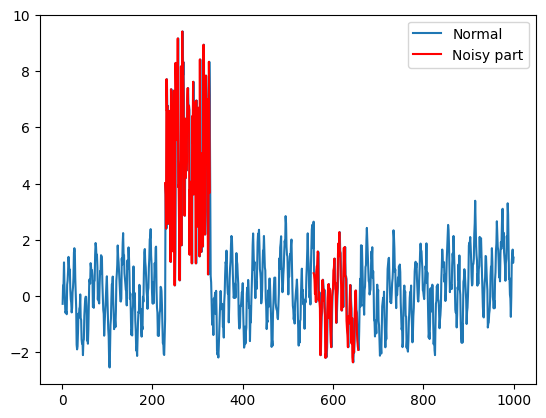

In [59]:
plt.plot(t, y_noise, label="Normal")
for t_noise in t_noises:
    plt.plot(t_noise, y_noise[t_noise], color="red")
plt.legend(["Normal", "Noisy part"])

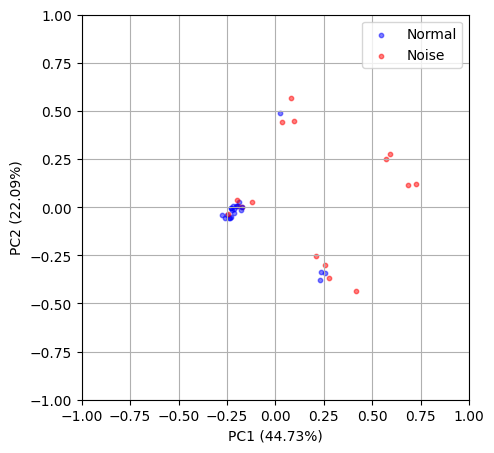

In [60]:
xs = scores[:, 0]
ys = scores[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(5,5))
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())
for c, (x, y) in zip(colors, zip(xs, ys)):
    plt.scatter(x * scalex,y * scaley, s=10, alpha=0.5, c=c, label=c)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.legend(["Normal", "Noise"])
leg= ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('red')

plt.grid()
plt.show()

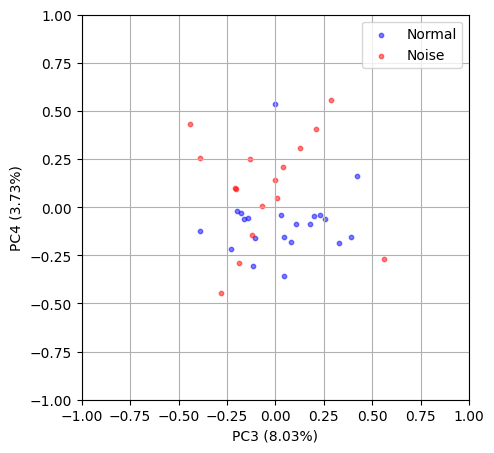

In [61]:
xs = scores[:, 2]
ys = scores[:, 3]

fig, ax = plt.subplots(1, 1, figsize=(5,5))
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())
for c, (x, y) in zip(colors, zip(xs, ys)):
    plt.scatter(x * scalex,y * scaley, s=10, alpha=0.5, c=c, label=c)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.2f}%)")
plt.ylabel(f"PC4 ({pca.explained_variance_ratio_[3]*100:.2f}%)")
plt.legend(["Normal", "Noise"])
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('red')

plt.grid()
plt.show()

### Same process for new data

In [62]:
# Create new signal with same characteristics but different irregular part
n = 1000
t = np.arange(1, n+1)
trend = 2 + 0.01 * t
seasonal = np.sin(2 * np.pi * t / 12)
cyclical = np.sin(2 * np.pi * t / 60)
irregular = np.random.randn(n) * 0.3
y_new = seasonal + cyclical  + trend + irregular

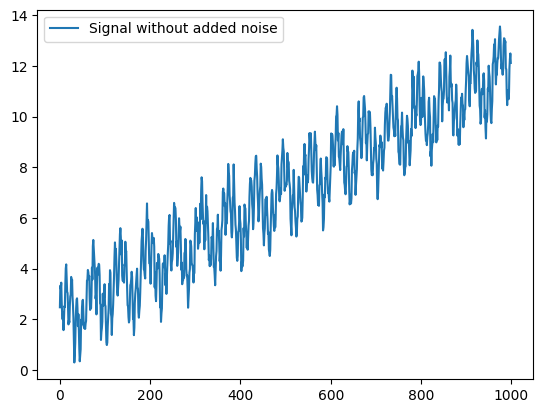

In [63]:
plt.plot(y_new)
plt.legend(["Signal without added noise"])

In [66]:
# Add same noise as in the last part but at other temporal locations

y_new_noise = y_new.copy()

t_new_noises = []
for _ in range(n_noises):
    t_new_noise = [int(np.random.uniform(0, n - noise_size))]
    t_new_noise.append(t_new_noise[0] + noise_size)
    t_new_noises.append(range(t_new_noise[0], t_new_noise[1]))

for t_noise, noise in zip(t_new_noises, noises):
    y_new_noise[t_noise] = y_new_noise[t_noise] + noise

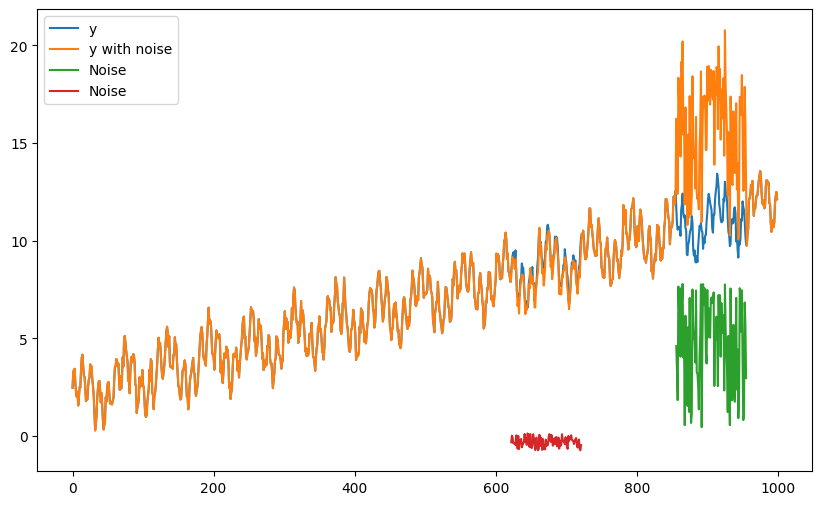

In [67]:
plt.subplots(figsize=(10, 6))
plt.plot(y_new, label="y")
plt.plot(y_new_noise, label="y with noise")
#plt.plot(trend, label="trend")
#plt.plot(seasonal, label="seasonal")
#plt.plot(cyclical, label="cyclical")
#plt.plot(irregular, label="irregular")
for t_noise, noise in zip(t_new_noises, noises):
    plt.plot(t_noise, noise, label="Noise")
plt.legend()

In [68]:
# Calcualte IMFs of signal
IMFs_new = emd(y_new_noise)

In [69]:
# Detrend signal using last IMF 
y_new_noise = y_new_noise -IMFs_new[-1]

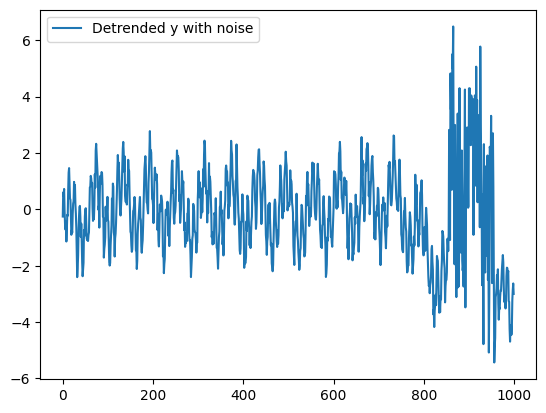

In [71]:
plt.plot(y_new_noise)
plt.legend(["Detrended y with noise"])

In [72]:
# Create windows of y and t
window = SlidingWindow(size=100, stride = 25)

y_new_windows = window.fit_transform(y_new_noise)
t_new_windows = window.fit_transform(t)

In [73]:
# Calculate features for new signal
selected_imfs = [1, 2, 3, 4, 5]
dwt_level = 5

all_features_new = get_all_features(y_windows=y_new_windows, selected_imfs=selected_imfs, dwt_level=dwt_level)

/home/emil/anaconda3/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=100
  return f(*args, **kwargs)
/home/emil/anaconda3/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=4
  return f(*args, **kwargs)
/home/emil/anaconda3/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=7
  return f(*args, **kwargs)
/home/emil/anaconda3/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=13
  return f(*args, **kwargs)
/home/emil/anaconda3/envs/drilling/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=25
  return f(*args, **kwargs)
/home/emil/anaconda3/envs/drilling/lib/python3.10/s

In [74]:
# Compute scores using same PCA as earlier
scores = pca.fit_transform(all_features_new)

In [78]:
# Color label the socres according to if they are a part of the noise or not
colors = []
for t_window in t_new_windows:
    is_in = False
    for t_noise in t_new_noises:
        if np.any(np.isin(t_noise, t_window)):
            is_in = True
            break
    if is_in:
        colors.append("red")
    else:
        colors.append("blue")

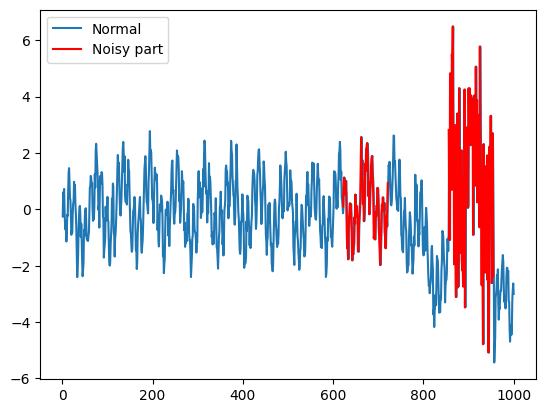

In [79]:
plt.plot(t, y_new_noise, label="Normal")
for t_noise in t_new_noises:
    plt.plot(t_noise, y_new_noise[t_noise], color="red")
plt.legend(["Normal", "Noisy part"])

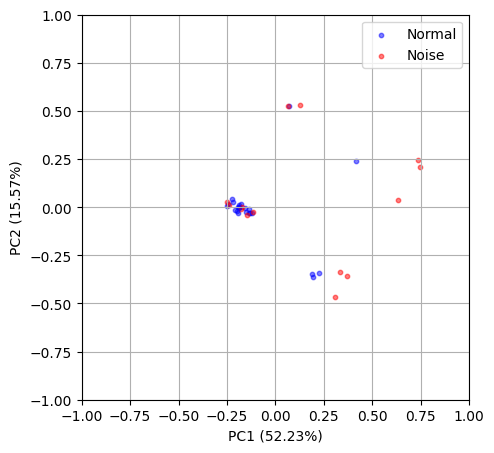

In [80]:
xs = scores[:, 0]
ys = scores[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(5,5))
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())
for c, (x, y) in zip(colors, zip(xs, ys)):
    plt.scatter(x * scalex,y * scaley, s=10, alpha=0.5, c=c, label=c)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.legend(["Normal", "Noise"])
leg= ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('red')

plt.grid()
plt.show()

## Spectogram of DWT

/tmp/ipykernel_302786/3409278624.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cc = np.concatenate(np.abs([cc, np.array([np.repeat(coeffs[levels - 1 - i], pow(2, i + 1))])]))


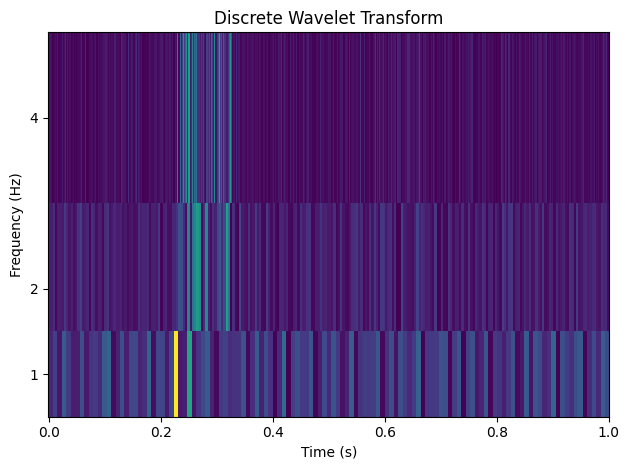

In [85]:
# Calculate and plot spectogram of wavelet transformed orignial signal

w = pywt.Wavelet('haar')
levels = 3
coeffs = pywt.wavedec(y_noise, w, level=levels)

cc = np.abs(np.array([coeffs[-1]]))
for i in range(levels - 1):
    cc = np.concatenate(np.abs([cc, np.array([np.repeat(coeffs[levels - 1 - i], pow(2, i + 1))])]))

plt.figure()
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Discrete Wavelet Transform')
# X-axis has a linear scale (time)
x = np.linspace(start=0, stop=1, num=n//2)
# Y-axis has a logarithmic scale (frequency)
y = np.logspace(start=levels-1, stop=0, num=levels, base=2)
X, Y = np.meshgrid(x, y)
plt.pcolormesh(X, Y, cc)

use_log_scale = False

if use_log_scale:
    plt.yscale('log')
else:
    yticks = [pow(2, i) for i in range(levels)]
    plt.yticks(yticks)

plt.tight_layout()
plt.show()

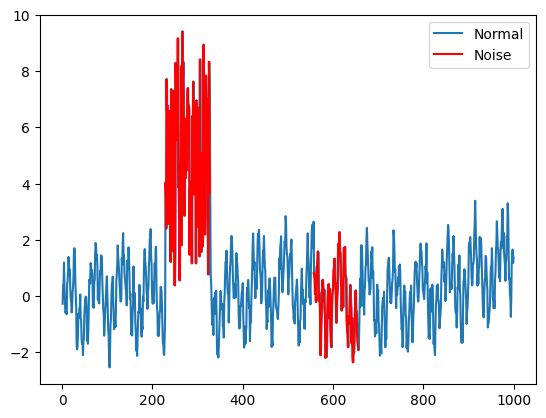

In [82]:
plt.plot(t, y_noise, label="Normal")
for t_noise in t_noises:
    plt.plot(t_noise, y_noise[t_noise], color="red")
plt.legend(["Normal", "Noise"])

/tmp/ipykernel_302786/1419196795.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cc = np.concatenate(np.abs([cc, np.array([np.repeat(coeffs[levels - 1 - i], pow(2, i + 1))])]))


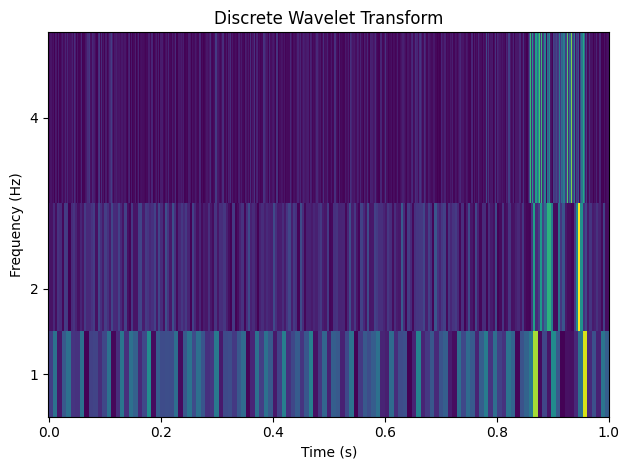

In [86]:
# Calculate and plot spectogram of wavelet transformed new signal

w = pywt.Wavelet('haar')
levels = 3
coeffs = pywt.wavedec(y_new_noise, w, level=levels)

cc = np.abs(np.array([coeffs[-1]]))
for i in range(levels - 1):
    cc = np.concatenate(np.abs([cc, np.array([np.repeat(coeffs[levels - 1 - i], pow(2, i + 1))])]))

plt.figure()
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Discrete Wavelet Transform')
# X-axis has a linear scale (time)
x = np.linspace(start=0, stop=1, num=n//2)
# Y-axis has a logarithmic scale (frequency)
y = np.logspace(start=levels-1, stop=0, num=levels, base=2)
X, Y = np.meshgrid(x, y)
plt.pcolormesh(X, Y, cc)

use_log_scale = False

if use_log_scale:
    plt.yscale('log')
else:
    yticks = [pow(2, i) for i in range(levels)]
    plt.yticks(yticks)

plt.tight_layout()
plt.show()

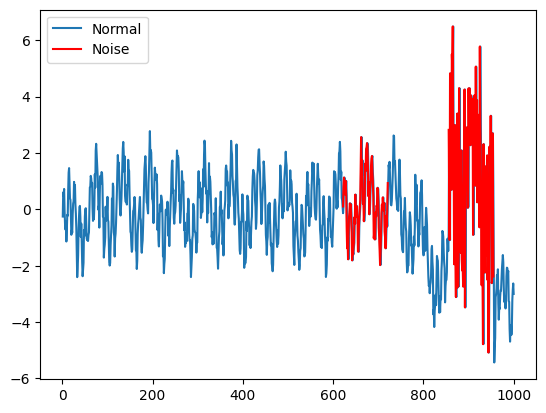

In [84]:
plt.plot(t, y_new_noise, label="Normal")
for t_noise in t_new_noises:
    plt.plot(t_noise, y_new_noise[t_noise], color="red")
plt.legend(["Normal", "Noise"])